In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

sys.path.append('../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.default import PASSING_DEFAULT
from common.video import Capture
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.38it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 15.54it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 23.55it/s]


# 特徴量を抽出
position + keypoints

In [7]:
def get_frame_max_coor(room_num, date):
    video_path = os.path.join(common.root, 'video', room_num, date, '01.mp4')
    cap = Capture(video_path)
    frame = cap.read()
    max_coor = frame.shape[:2]
    return max_coor[1::-1]

def get_field_max_coor(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    max_coor = field_raw.shape[:2]
    return max_coor

frame_max_coors = {}
field_max_coors = {}
for setting in data_settings:
    frame_max_coors[setting['room_num']] = get_frame_max_coor(setting['room_num'], setting['date'])
    field_max_coors[setting['room_num']] = get_field_max_coor(setting['room_num'])

In [8]:
min_len = 30

data_dict = {}
for key, ind in individuals.items():
    room_num = key.split('_')[0]
    pos_dict = ind.indicator_dict['position']  # {frame_num: position}
    kps_dict = ind.keypoints  # {frame_num: keypoints}

    if len(pos_dict) > min_len:
        feature_dict = {}
        for frame_num in pos_dict.keys():
            # normalize
            pos = np.array(pos_dict[frame_num]) / field_max_coors[room_num]
            kps = np.array(kps_dict[frame_num]) / frame_max_coors[room_num]
            
            feature_dict[frame_num] = [pos.tolist()] + kps.tolist()
        data_dict[key] = feature_dict

## nanを穴埋めする

In [44]:
def fill_nan(feature_dict, window=3):
    min_frame_num = min(feature_dict.keys())
    max_frame_num = max(feature_dict.keys())
    pre = feature_dict[min_frame_num]
    
    copy_f_lst = []
    for frame_num in range(min_frame_num, max_frame_num + 1):
        if frame_num in feature_dict:
            f = feature_dict[frame_num]
            if True in np.isnan(f):
                # 一部のnanを前フレームからコピー
                f = np.where(np.isnan(f), pre, f).copy()
            copy_f_lst.append(f)
            pre = f.copy()
        else:
            # 前のフレームからコピー
            copy_f_lst.append(pre)

    # 残ったnanは移動平均で穴埋め
    ma_f_lst = []
    for i in range(0, len(copy_f_lst) - window):
        means = np.nanmean(copy_f_lst[i:i + window], axis=0)
        for f in copy_f_lst[i:i + window]:
            if True in np.isnan(f):
                f = np.where(np.isnan(f), means, f).copy()

            if len(ma_f_lst) <= i + window:
                ma_f_lst.append(f)

    return  np.array(ma_f_lst)


data_dict_fill_nan = {}
for key, feature_dict in tqdm(data_dict.items()):
    f_arr = fill_nan(feature_dict, window=3)
    if len(f_arr) > 0:
        data_dict_fill_nan[key] = f_arr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [00:12<00:00, 63.11it/s]


# オートエンコーダ

In [16]:
# model settings
SEQ_LEN = 64
Z_SIZE = 64  # feature size
N_LAYERS = 1
DROPOUT = 0

# leraning rate
LR = 0.001

# training and data settings
EPOCH = 50
BATCH_SIZE = 64
TRAIN_RATIO = 0.7
VAL_RATIO = 0.05

kwargs = {
    'seq_len': SEQ_LEN,
    'n_features': list(data_dict_fill_nan.values())[0].shape[1] * 2,
    'hidden_size1': Z_SIZE * 4,
    'hidden_size2': Z_SIZE * 2,
    'z_size': Z_SIZE,
    'n_layers': N_LAYERS,
    'dropout': DROPOUT,
    'lr': LR,
    'epoch': EPOCH,
    'batch_size':BATCH_SIZE,
    'device': device,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット作成

In [17]:
class MyDataset(Dataset):
    def __init__(self, data_dict, keys, **kwargs):
        seq_len = kwargs['seq_len']
        self.x = []
        for key in tqdm(keys):
            feature = data_dict[key]
            for i in range(len(feature) - seq_len + 1):
                self.x.append(feature.reshape(-1, 18 * 2).tolist()[i:i + seq_len])
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return tensor(self.x[index]).to(self.device)

    def __len__(self):
        return len(self.x)

In [18]:
random_keys = np.random.choice(
    list(data_dict_fill_nan.keys()),
    size=len(data_dict_fill_nan),
    replace=False
)
train_len = int(len(data_dict_fill_nan) * TRAIN_RATIO)
val_len = int(len(data_dict_fill_nan) * VAL_RATIO)
train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

train_loader = DataLoader(
    MyDataset(data_dict_fill_nan, train_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(
    MyDataset(data_dict_fill_nan, val_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    MyDataset(data_dict_fill_nan, test_keys, **kwargs), batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:04<00:00, 45.14it/s]


## モデル生成

In [19]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__()
        self.seq_len = kwargs['seq_len']
        self.n_features = kwargs['n_features']
        self.z_size = kwargs['z_size']

        self.rnn1 = nn.LSTM(
            input_size=kwargs['n_features'],
            hidden_size=kwargs['hidden_size1'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=kwargs['hidden_size1'],
            hidden_size=kwargs['hidden_size2'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=kwargs['hidden_size2'],
            hidden_size=kwargs['z_size'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((-1, self.seq_len, self.n_features))
        # x.shape = (batch_size, seq_len, n_features)
        
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
        _, (z, _) = self.rnn3(x)
        # x.shape = (batch_size, seq_len, z_size)
        # z.shape = (1, batch_size, z_size)
        
        return z.reshape(-1, self.z_size)


class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__()
        self.seq_len = kwargs['seq_len']
        self.z_size = kwargs['z_size']
        self.n_layers = kwargs['n_layers']

        self.rnn1 = nn.LSTM(
            input_size=kwargs['z_size'],
            hidden_size=kwargs['z_size'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=kwargs['z_size'],
            hidden_size=kwargs['hidden_size2'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=kwargs['hidden_size2'],
            hidden_size=kwargs['hidden_size1'],
            num_layers=kwargs['n_layers'],
            dropout=kwargs['dropout'],
            batch_first=True
        )
        self.output_layer = nn.Linear(kwargs['hidden_size1'], kwargs['n_features'])

    def forward(self, z):
        z = z.repeat(1, self.seq_len).reshape(-1, self.seq_len, self.z_size)
        # z.shape = (batch_size, seq_len, self.z_size)
        
        x, (_, _) = self.rnn1(z)
        x, (_, _) = self.rnn2(x)
        x, (_, _) = self.rnn3(x)
        x = self.output_layer(x)
        # x.shape = (batch_size, seq_len, n_feature)

        return x


class RecurrentAutoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(**kwargs).to(kwargs['device'])
        self.decoder = Decoder(**kwargs).to(kwargs['device'])
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y, z

In [20]:
# create new model
model = RecurrentAutoencoder(**kwargs)
model = model.to(kwargs['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
criterion = nn.MSELoss().to(kwargs['device'])

model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(36, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
    (rnn3): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (rnn3): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=36, bias=True)
  )
)

## 学習

In [21]:
n_epochs = kwargs['epoch']
history = dict(train=[], val=[])
for epoch in range(1, n_epochs + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    for x in train_loader:
        optimizer.zero_grad()
        y, _ = model(x)

        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x in val_loader:
            y, _ = model(x)
            loss = criterion(x, y)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{(n_epochs)}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}, time: {te - ts:.2f}")

Epoch[1/50] train loss: 0.00725, val loss: 0.00259, time: 29.33
Epoch[2/50] train loss: 0.00103, val loss: 0.00122, time: 28.75
Epoch[3/50] train loss: 0.00065, val loss: 0.00104, time: 28.77
Epoch[4/50] train loss: 0.00057, val loss: 0.00106, time: 28.88
Epoch[5/50] train loss: 0.00050, val loss: 0.00109, time: 28.97
Epoch[6/50] train loss: 0.00043, val loss: 0.00091, time: 28.83
Epoch[7/50] train loss: 0.00037, val loss: 0.00082, time: 28.60
Epoch[8/50] train loss: 0.00034, val loss: 0.00084, time: 28.75
Epoch[9/50] train loss: 0.00028, val loss: 0.00078, time: 28.72
Epoch[10/50] train loss: 0.00027, val loss: 0.00071, time: 28.68
Epoch[11/50] train loss: 0.00025, val loss: 0.00071, time: 28.61
Epoch[12/50] train loss: 0.00022, val loss: 0.00073, time: 28.64
Epoch[13/50] train loss: 0.00022, val loss: 0.00076, time: 28.70
Epoch[14/50] train loss: 0.00020, val loss: 0.00066, time: 28.68
Epoch[15/50] train loss: 0.00018, val loss: 0.00070, time: 28.76
Epoch[16/50] train loss: 0.00017, 

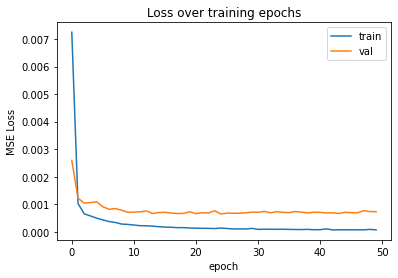

In [22]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

In [23]:
path = f'{common.root}/model/pass_model_autoencoder_{Z_SIZE}.pth'
torch.save(model, path)

## 検証

In [24]:
path = f'{common.root}/model/pass_model_autoencoder_{Z_SIZE}.pth'
model = torch.load(path)
model = model.to(kwargs['device'])

In [25]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(36, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
    (rnn3): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (rnn3): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=36, bias=True)
  )
)

In [26]:
predictions, losses = [], []
with torch.no_grad():
    model = model.eval()
    for x in test_loader:
        y, _ = model(x)

        loss = criterion(x, y)
        predictions.append(y.cpu().numpy().flatten())
        losses.append(loss.item())

0.0003965228795328416


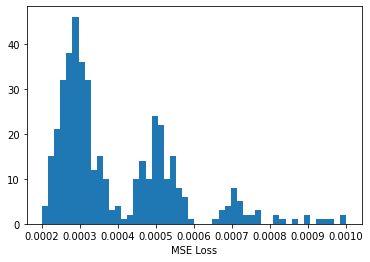

In [27]:
print(np.mean(losses))
plt.hist(losses, bins=50)
plt.xlabel('MSE Loss')
plt.show()

### 特徴量の分布をプロット

In [28]:
# testデータからデータを目視で選択する
print(sorted(test_keys))

['02_01_17', '02_02_0', '02_02_1', '02_02_17', '02_02_25', '02_02_28', '02_02_31', '02_02_33', '02_02_8', '02_02_9', '02_03_17', '02_03_24', '02_03_5', '02_03_7', '02_03_9', '02_04_0', '02_04_14', '02_05_10', '02_05_2', '02_06_7', '02_06_8', '02_06_9', '02_07_4', '02_07_5', '02_08_17', '02_08_5', '02_08_7', '02_08_8', '02_09_10', '02_09_17', '02_09_2', '02_09_3', '02_09_9', '02_10_13', '02_10_14', '02_10_16', '02_10_18', '02_10_19', '02_10_36', '02_10_39', '02_11_3', '02_11_5', '02_11_9', '02_12_1', '02_12_15', '02_12_3', '02_12_4', '02_12_8', '02_13_12', '02_13_2', '02_13_9', '02_14_5', '02_15_0', '02_15_10', '02_15_13', '02_15_3', '02_15_39', '02_15_4', '02_15_44', '02_15_58', '02_16_14', '02_16_3', '02_16_4', '02_16_8', '02_19_3', '02_19_4', '02_20_2', '02_21_0', '02_21_11', '02_21_4', '02_21_5', '02_22_2', '02_22_8', '02_23_10', '02_23_16', '02_23_5', '08_01_1', '08_02_3', '08_02_4', '08_02_5', '08_03_17', '08_03_4', '08_04_0', '08_04_15', '08_05_2', '08_05_5', '08_06_1', '08_06_5'

In [29]:
types = [
    'surgeon',
    'scrub nurse',
    'circulator',
    'anesthesiologist',
    'medical intern',
]
keys = [
    {'key':'02_02_1',  'type':2},
    {'key':'02_02_2',  'type':1},
    {'key':'02_11_0',  'type':4},
    {'key':'02_11_1',  'type':4},
    {'key':'02_11_2',  'type':2},
    {'key':'09_04_3',  'type':2},
    {'key':'09_04_1',  'type':1},
    {'key':'09_04_5',  'type':0},
]

In [30]:
graph = [
    # ========== 4 ============ 9 =========== 14 =====
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Nose
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEye
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REye
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEar
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REar
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # LShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # RShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # LElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # RElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # LHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # RHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # LKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # RKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LAnkle
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RAnkle
]

def plot_keypoints(img, keypoints, color=(255, 0, 0)):
    if np.any(np.isnan(keypoints)):
        return img
    for i in range(len(keypoints) - 1):
        for j in range(i + 1, len(keypoints)):
            p1 = tuple(keypoints[i].astype(int))
            p2 = tuple(keypoints[j].astype(int))
            if graph[i][j] == 1:
                img = cv2.line(img, p1, p2, color, 3)
    return img

[0.22319838 0.53817115] [116.30564332 178.45292664]


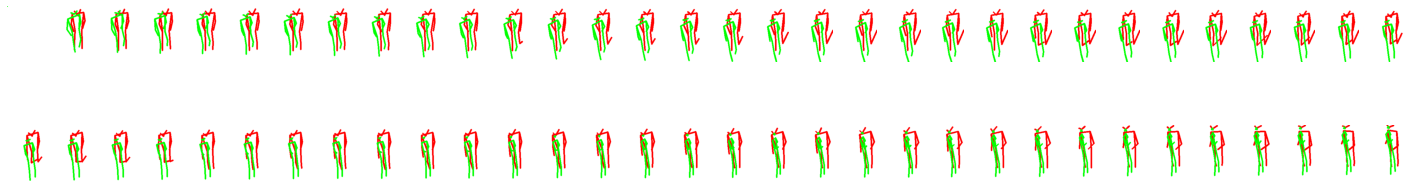

In [55]:
key_idx = 0
frame_num = 64
ratio = 500

feature = data_dict_fill_nan[keys[key_idx]['key']]
test_feature = feature[frame_num:frame_num + SEQ_LEN]

model.eval()
with torch.no_grad():
    out, _ = model(tensor(test_feature).float().to(kwargs['device']))

    test_feature = test_feature.reshape(SEQ_LEN, 18, 2)
    out = out.cpu().numpy().flatten().reshape(SEQ_LEN, 18, 2)

    mins = np.min(
        np.append(np.min(test_feature[1:], axis=1), np.min(out[1:], axis=1), axis=0),
        axis=0
    )
    maxs = np.max(
        np.append(np.max(test_feature, axis=1), np.max(out, axis=1), axis=0),
        axis=0
    )
    print(mins, maxs)
    
    test_feature[1:] = (test_feature[1:] - mins) * ratio
    out[1:] = (out[1:] - mins) * ratio
    size = (maxs - mins).astype(int)
    
    fig = plt.figure(figsize=(25, 4))
    for i in range(SEQ_LEN):
        ax = fig.add_subplot(2, int(SEQ_LEN / 2), i + 1)
        img = np.ones((size[1], size[0], 3), np.uint8) * 255
        img = plot_keypoints(img, test_feature[i, 1:, :], (255, 0, 0))
        img = plot_keypoints(img, out[i, 1:, :], (0, 255, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [53]:
n_components = 2

z_lst = []
z_dict = {}
model.eval()
with torch.no_grad():
    for key in tqdm(keys):
        key = key['key']
        kps_arr = data_dict_fill_nan[key]
        z_dict[key] = []
        
        for i in range(len(kps_arr) - SEQ_LEN + 1):
            _, z = model(tensor(kps_arr[i:i + SEQ_LEN]).float().to(kwargs['device']))
            z = z.cpu().numpy().flatten()
            z_lst.append(z)
            z_dict[key].append(z)
        
        z_dict[key] = np.array(z_dict[key])

pca = PCA(n_components=n_components)
pca.fit(z_lst)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.22s/it]


PCA(n_components=2)

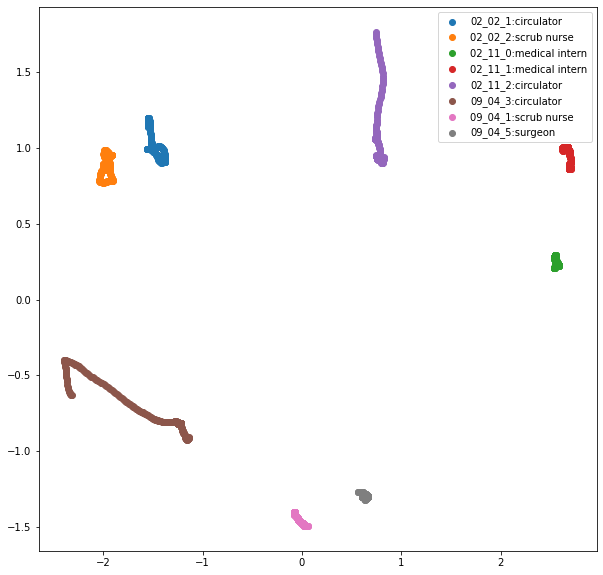

In [54]:
fig = plt.figure(figsize=(10,10))
for key in keys:
    z_lst = z_dict[key['key']]
    z_pca = pca.transform(z_lst)
    x = z_pca.T[0]
    y = z_pca.T[1]
    k, t = key['key'], types[key['type']]
    plt.scatter(x, y, label=f'{k}:{t}')
plt.legend()